In [1]:
import numpy as np
import bilby 
import pycbc 
import sys
import matplotlib.pyplot as plt
import pandas as pd
from glasflow import RealNVP, CouplingNSF

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
import os
import json
import glob



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [6]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#from .utils import PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
from river.models.utils import *
from river.data.utils import *

import river.data
from river.data.datagenerator import DataGeneratorBilbyFD
from river.data.dataset import DatasetSVDStrainFDFromSVDWFonGPU, DatasetSVDStrainFDFromSVDWFonGPUBatch
from river.data.dataset import DatasetConvStrainFDFromSVDWFonGPU, DatasetConvStrainFDFromSVDWFonGPUBatch
from river.data.dataset_multiband import DatasetMBStrainFDFromMBWFonGPU, DatasetMBStrainFDFromMBWFonGPUBatch

#import river.data.utils as datautils
from river.data.utils import *
from river.data.reparameterize import *

from river.models import embedding
from river.models.utils import *
#from river.models.embedding.pca import project_strain_data_FDAPhi
from river.models.embedding.conv import EmbeddingConv1D, EmbeddingConv2D
from river.models.embedding.mlp import EmbeddingMLP1D
from river.models.inference.cnf import GlasflowEmbdding

# Make test data

In [3]:
source_type = 'BNS'
detector_names = ['H1', 'L1', 'V1'] 
duration = 32
f_low = 50
f_high = 1024

f_ref = 20
sampling_frequency = 2048
waveform_approximant = 'IMRPhenomPv2_NRTidal'
parameter_names = PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
PSD_type = 'bilby_default' #'zero_noise' bilby_default
use_sealgw_detector = True

Vhfile="/home/qian.hu/mlpe/river/test/outputs/Vh_50Hz1024Hz32s.pickle"

data_generator = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
            f_high=f_high)

07:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using bilby_default PSDs to generate data.


In [13]:
config_path = '/home/qian.hu/mlpe/river/scripts/trained_models/BNS20MB_8M_17D_4'
with open(f"{config_path}/config.json", 'r') as f:
    config = json.load(f)
        
config_datagenerator = config['data_generator_parameters']
config_training = config['training_parameters']
config_model = config['model_parameters']
config_precaldata = config['precaldata_parameters']


dmin = config_datagenerator['d_min']
dmax = config_datagenerator['d_max']
dpower = config_datagenerator['d_power']
tc_min = config_datagenerator['tc_min']
tc_max = config_datagenerator['tc_max']
timing_std = config_datagenerator['timing_std']
full_duration = config_datagenerator['full_duration']

detector_names = config_datagenerator['detector_names']

asd_folder = config_precaldata['asd_path']

batch_size_train = config_training['batch_size_train']
minibatch_size_train = config_training['minibatch_size_train']
batch_size_valid = config_training['batch_size_valid']
minibatch_size_valid = config_training['minibatch_size_valid']

wf_folder_train = config_precaldata['train']['folder']
wf_folder_valid = config_precaldata['valid']['folder']

device='cuda'

In [27]:
validfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/valid'
trainfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/train'
#noisefolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin/noise/design'

valid_filenames = glob.glob(f"{validfolder}/batch*/*.h5")
train_filenames = glob.glob(f"{trainfolder}/batch*/*.h5")

add_noise = True
do_reparameterize = True
fix_extrinsic = False


dataset_valid = DatasetMBStrainFDFromMBWFonGPU(wf_folder = wf_folder_valid,
                                                    asd_folder = asd_folder,
                                                    parameter_names = PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, 
                                                    full_duration = full_duration, 
                                                    detector_names = detector_names,
                                                    dmin = dmin,
                                                    dmax = dmax,
                                                    dpower = dpower, 
                                                    tc_min = tc_min,
                                                    tc_max = tc_max,
                                                    timing_std = timing_std,
                                                    device = device,
                                                    #minibatch_size = minibatch_size_valid,
                                                    add_noise = True,
                                                    fix_extrinsic = fix_extrinsic,
                                                    reparameterize = True,
                                                    random_asd = False)

# Load model

In [18]:
config_dict = config
model = GlasflowEmbdding(config_dict).to(device)


In [19]:
ckpt_dir = config_dict['ckpt_dir']
ckpt_path = f'{ckpt_dir}/checkpoint.pickle'

In [20]:

checkpoint = torch.load(ckpt_path, map_location=device)
start_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict']) 

print(f'Loaded states from {ckpt_path}, epoch={start_epoch}.')

Loaded states from trained_models/BNS20MB_8M_17D_4/checkpoint.pickle, epoch=2.


In [28]:
model.eval()

dataloader = DataLoader(dataset_valid, batch_size=1, shuffle=False)


In [18]:
max_event = 1
Nsample=4000

parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase', 
                   'ra', 'dec', 'psi', 'geocent_time', 'luminosity_distance']
loss_list = []
sample_list = []
injection_parameters_list = []
with torch.no_grad():
    i = 0
    for theta, x in dataloader:
        theta = theta.to(device)
        x = x.to(device)

        if type(dataset_valid) in [DatasetSVDStrainFDFromSVDWFonGPUBatch, DatasetConvStrainFDFromSVDWFonGPUBatch]:
            #print('w3')
            theta = theta.view(dataset.minibatch_size, theta.shape[-1])
            x = x.view(dataset.minibatch_size, x.shape[-2], x.shape[-1])

        
        lenx = x.shape[-1]
        lentheta = theta.shape[-1]
        loss = -model.log_prob(theta, x=x).mean()
        samples = model.sample(Nsample, x=x)

        inj_para = {}
        for j, paraname in enumerate(parameter_names):
            inj_para[paraname] = inverse_reparameterize(theta[0][j].cpu().numpy(), paraname)

        loss_list.append(loss.detach().cpu())
        sample_list.append(samples.cpu().numpy())
        injection_parameters_list.append(inj_para)
        i+=1
        if i>=max_event:
            break
            
    samples = np.array(sample_list)
    samples = torch.from_numpy(samples)
    samples = samples.movedim(1,2)

In [24]:
theta.shape

torch.Size([1, 10, 17])

In [29]:
cond_list = []
for theta, x in dataloader:
    cond_list.append(model.condition(x).detach().cpu())

/home/qian.hu/mlpe/river/river/data/dataset_multiband.py:187: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  theta = torch.tensor(theta_array, dtype=torch.float32).to(self.device).T


In [30]:
c1 = cond_list[0]
c2 = cond_list[22]
c3 = cond_list[222]

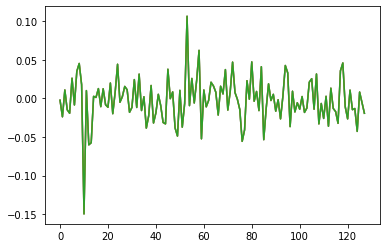

In [31]:
plt.plot(c1[0])
plt.plot(c2[0])
plt.plot(c3[0])

In [26]:
def mysample_GlasNSFWarpper(model, dataset, parameter_names=None, device='cpu', Nsample=5000, max_event=1e3):
    model.eval()
    loss_list = []
    sample_list = []
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    injection_parameters_list = []
    with torch.no_grad():
        i = 0
        for theta, x in dataloader:
            theta = theta.to(device)
            x = x.to(device)
            
            if type(dataset) in [DatasetSVDStrainFDFromSVDWFonGPUBatch, DatasetConvStrainFDFromSVDWFonGPUBatch]:
                #print('w3')
                theta = theta.view(dataset.minibatch_size, theta.shape[-1])
                x = x.view(dataset.minibatch_size, x.shape[-2], x.shape[-1])
            
            
            lenx = x.shape[-1]
            lentheta = theta.shape[-1]
            loss = -model.log_prob(theta, x=x).mean()
            samples = model.sample(Nsample, x=x)
            
            inj_para = {}
            for j, paraname in enumerate(parameter_names):
                inj_para[paraname] = inverse_reparameterize(theta[0][j].cpu().numpy(), paraname)
                
            loss_list.append(loss.detach().cpu())
            sample_list.append(samples.cpu().numpy())
            injection_parameters_list.append(inj_para)
            i+=1
            if i>=max_event:
                break
            
    samples = np.array(sample_list)
    samples = torch.from_numpy(samples)

    return samples.movedim(1,2), loss_list, injection_parameters_list


In [27]:
if fix_extrinsic:
    parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
else:
    parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase', 
                   'ra', 'dec', 'psi', 'geocent_time', 'luminosity_distance']

sample_list, loss_list, injection_parameters_list =  mysample_GlasNSFWarpper(model, dataset_valid, parameter_names=parameter_names,
                                                                             device=device, Nsample=5000, max_event=100)



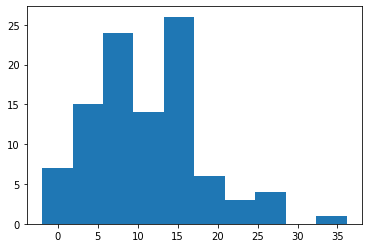

In [28]:
_ = plt.hist(loss_list)

In [29]:
def make_results(sample_list, parameter_names, injection_parameters_list=None):
    Nresult = len(sample_list)

    result_list = []
    for i in range(Nresult):
        result = bilby.gw.result.CompactBinaryCoalescenceResult()
        injection_parameters = {}
        posterior_dict = {}
        search_parameter_keys = []
        parameter_labels_with_unit = []
        for j,paraname in enumerate(parameter_names):
            '''
            if paraname=='chirp_mass':
                s = np.array(sample_list[i][j].cpu())
                s = 10**inverse_reparameterize(s, 'log10_chirp_mass')
                posterior_dict[paraname] = s
            else:
                posterior_dict[paraname] = inverse_reparameterize(np.array(sample_list[i][j].cpu()), paraname)
            '''
            posterior_dict[paraname] = inverse_reparameterize(np.array(sample_list[i][j].cpu()), paraname)
            search_parameter_keys.append(paraname)
            parameter_labels_with_unit.append(paraname)
        
        result.posterior = pd.DataFrame.from_dict(posterior_dict)
        result.injection_parameters = injection_parameters_list[i]
        
        #result.injection_parameters['chirp_mass'] = \
        #    reparameterize(torch.log10(inverse_reparameterize(result.injection_parameters['chirp_mass'], 'chirp_mass')), 'log10_chirp_mass')
        
        
        result.search_parameter_keys = search_parameter_keys
        result.parameter_labels_with_unit = parameter_labels_with_unit
        result_list.append(result)
    
    return result_list

In [30]:
#result_list = make_results(sample_list, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY)
result_list = make_results(sample_list, parameter_names, injection_parameters_list)

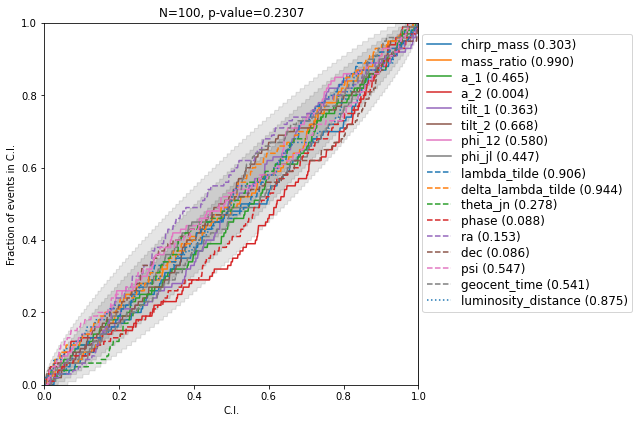

In [31]:
#fig = bilby.core.result.make_pp_plot(result_list, filename=None, save=False, confidence_interval=[0.68, 0.95, 0.997])
fig = make_pp_plot(result_list, filename = f"{config_path}/pp_plot.png", save=False, confidence_interval=[0.68, 0.95, 0.997])


In [38]:
look_index = np.argmin(loss_list)
#look_index = np.argmax(loss_list)
look_index = 1
result = result_list[look_index]
loss_list[look_index]

tensor(8.7197)

In [39]:
result.injection_parameters

{'chirp_mass': 1.8650802865981508,
 'mass_ratio': 0.9897151290866566,
 'a_1': 0.07263157538844961,
 'a_2': 0.08819133819798597,
 'tilt_1': 0.6081150222948893,
 'tilt_2': 1.8346337387566742,
 'phi_12': 4.0659467270407355,
 'phi_jl': 2.1023075393078257,
 'lambda_tilde': 2445.0013415444027,
 'delta_lambda_tilde': 379.06389917098454,
 'theta_jn': 2.7068188293240425,
 'phase': 4.517827987532903,
 'ra': 6.180699824837564,
 'dec': 0.04614289805579418,
 'psi': 1.3868193889680323,
 'geocent_time': -0.013929222685823204,
 'luminosity_distance': 173.63764824899351}

In [40]:
result.posterior

chirp_mass  mass_ratio       a_1       a_2    tilt_1    tilt_2  \
0       1.864196    0.844807  0.014471  0.069816  1.531643  1.162129   
1       1.866327    0.616578  0.074878  0.054843  2.590958  0.579039   
2       1.864329    0.806119  0.060846  0.077521  2.211596  1.581580   
3       1.869463    0.918033  0.034473  0.072408  1.989081  2.015231   
4       1.864787    0.819155  0.085763  0.084328  1.517650  2.346411   
...          ...         ...       ...       ...       ...       ...   
4995    1.867952    0.860801  0.062232  0.062986  1.480640  1.372708   
4996    1.869474    0.887128  0.032428  0.080543  2.472730  1.662210   
4997    1.872111    0.803401  0.046880  0.097392  1.420254  1.095099   
4998    1.866512    0.608183  0.040266  0.076747  0.737372  1.377770   
4999    1.866158    0.867928  0.007750  0.084987  1.033752  1.689072   

        phi_12    phi_jl  lambda_tilde  delta_lambda_tilde  theta_jn  \
0     5.264277  4.567979   1212.420044          -93.793365  0.560439   
1     4.450298  5.904537   3031.251221         -607.146667  0.036471   
2     1.983283  2.859028   4589.975586         -625.945435  2.812954   
3     4.663238  1.369091   1561.635254           60.750153  1.845233   
4     2.429183  1.882699   2212.487549          -69.091980  3.032169   
...        ...       ...           ...                 ...       ...   
4995  6.144289  2.150735   3187.143555         -759.748535  0.894799   
4996  3.237731  2.057020   2724.520508         -496.475769  2.168279   
4997  4.127584  3.452729   4180.611328         -843.524536  1.831864   
4998  3.327258  2.370466   1581.234985          216.723511  0.686495   
4999  2.083351  2.100051   4119.584473         -318.655548  1.080077   

         phase        ra       dec       psi  geocent_time  \
0     3.229868  3.201320  0.001234  2.215731     -0.080880   
1     3.450015  0.677484 -0.597272  1.717395      0.093106   
2     4.993454  3.340096 -0.050884  1.159479      0.029596   
3     2.172105  3.486704 -0.019885  2.220370      0.024114   
4     5.503402  2.918973 -0.129679  1.342102      0.025590   
...        ...       ...       ...       ...           ...   
4995  3.417062  3.413640 -0.261751  0.852834      0.055955   
4996  3.026256  3.330538 -0.287899  1.069633      0.007074   
4997  1.890831  0.375846  0.377817  0.255165      0.022494   
4998  3.060079  3.731334  0.002449  0.516572     -0.013261   
4999  2.911003  0.114908  0.293045  0.175929     -0.057071   

      luminosity_distance  
0              160.115250  
1              147.368332  
2              119.226067  
3              140.520782  
4              140.852692  
...                   ...  
4995           126.638107  
4996           125.784767  
4997           149.254593  
4998           150.450256  
4999           157.152161  

[5000 rows x 17 columns]

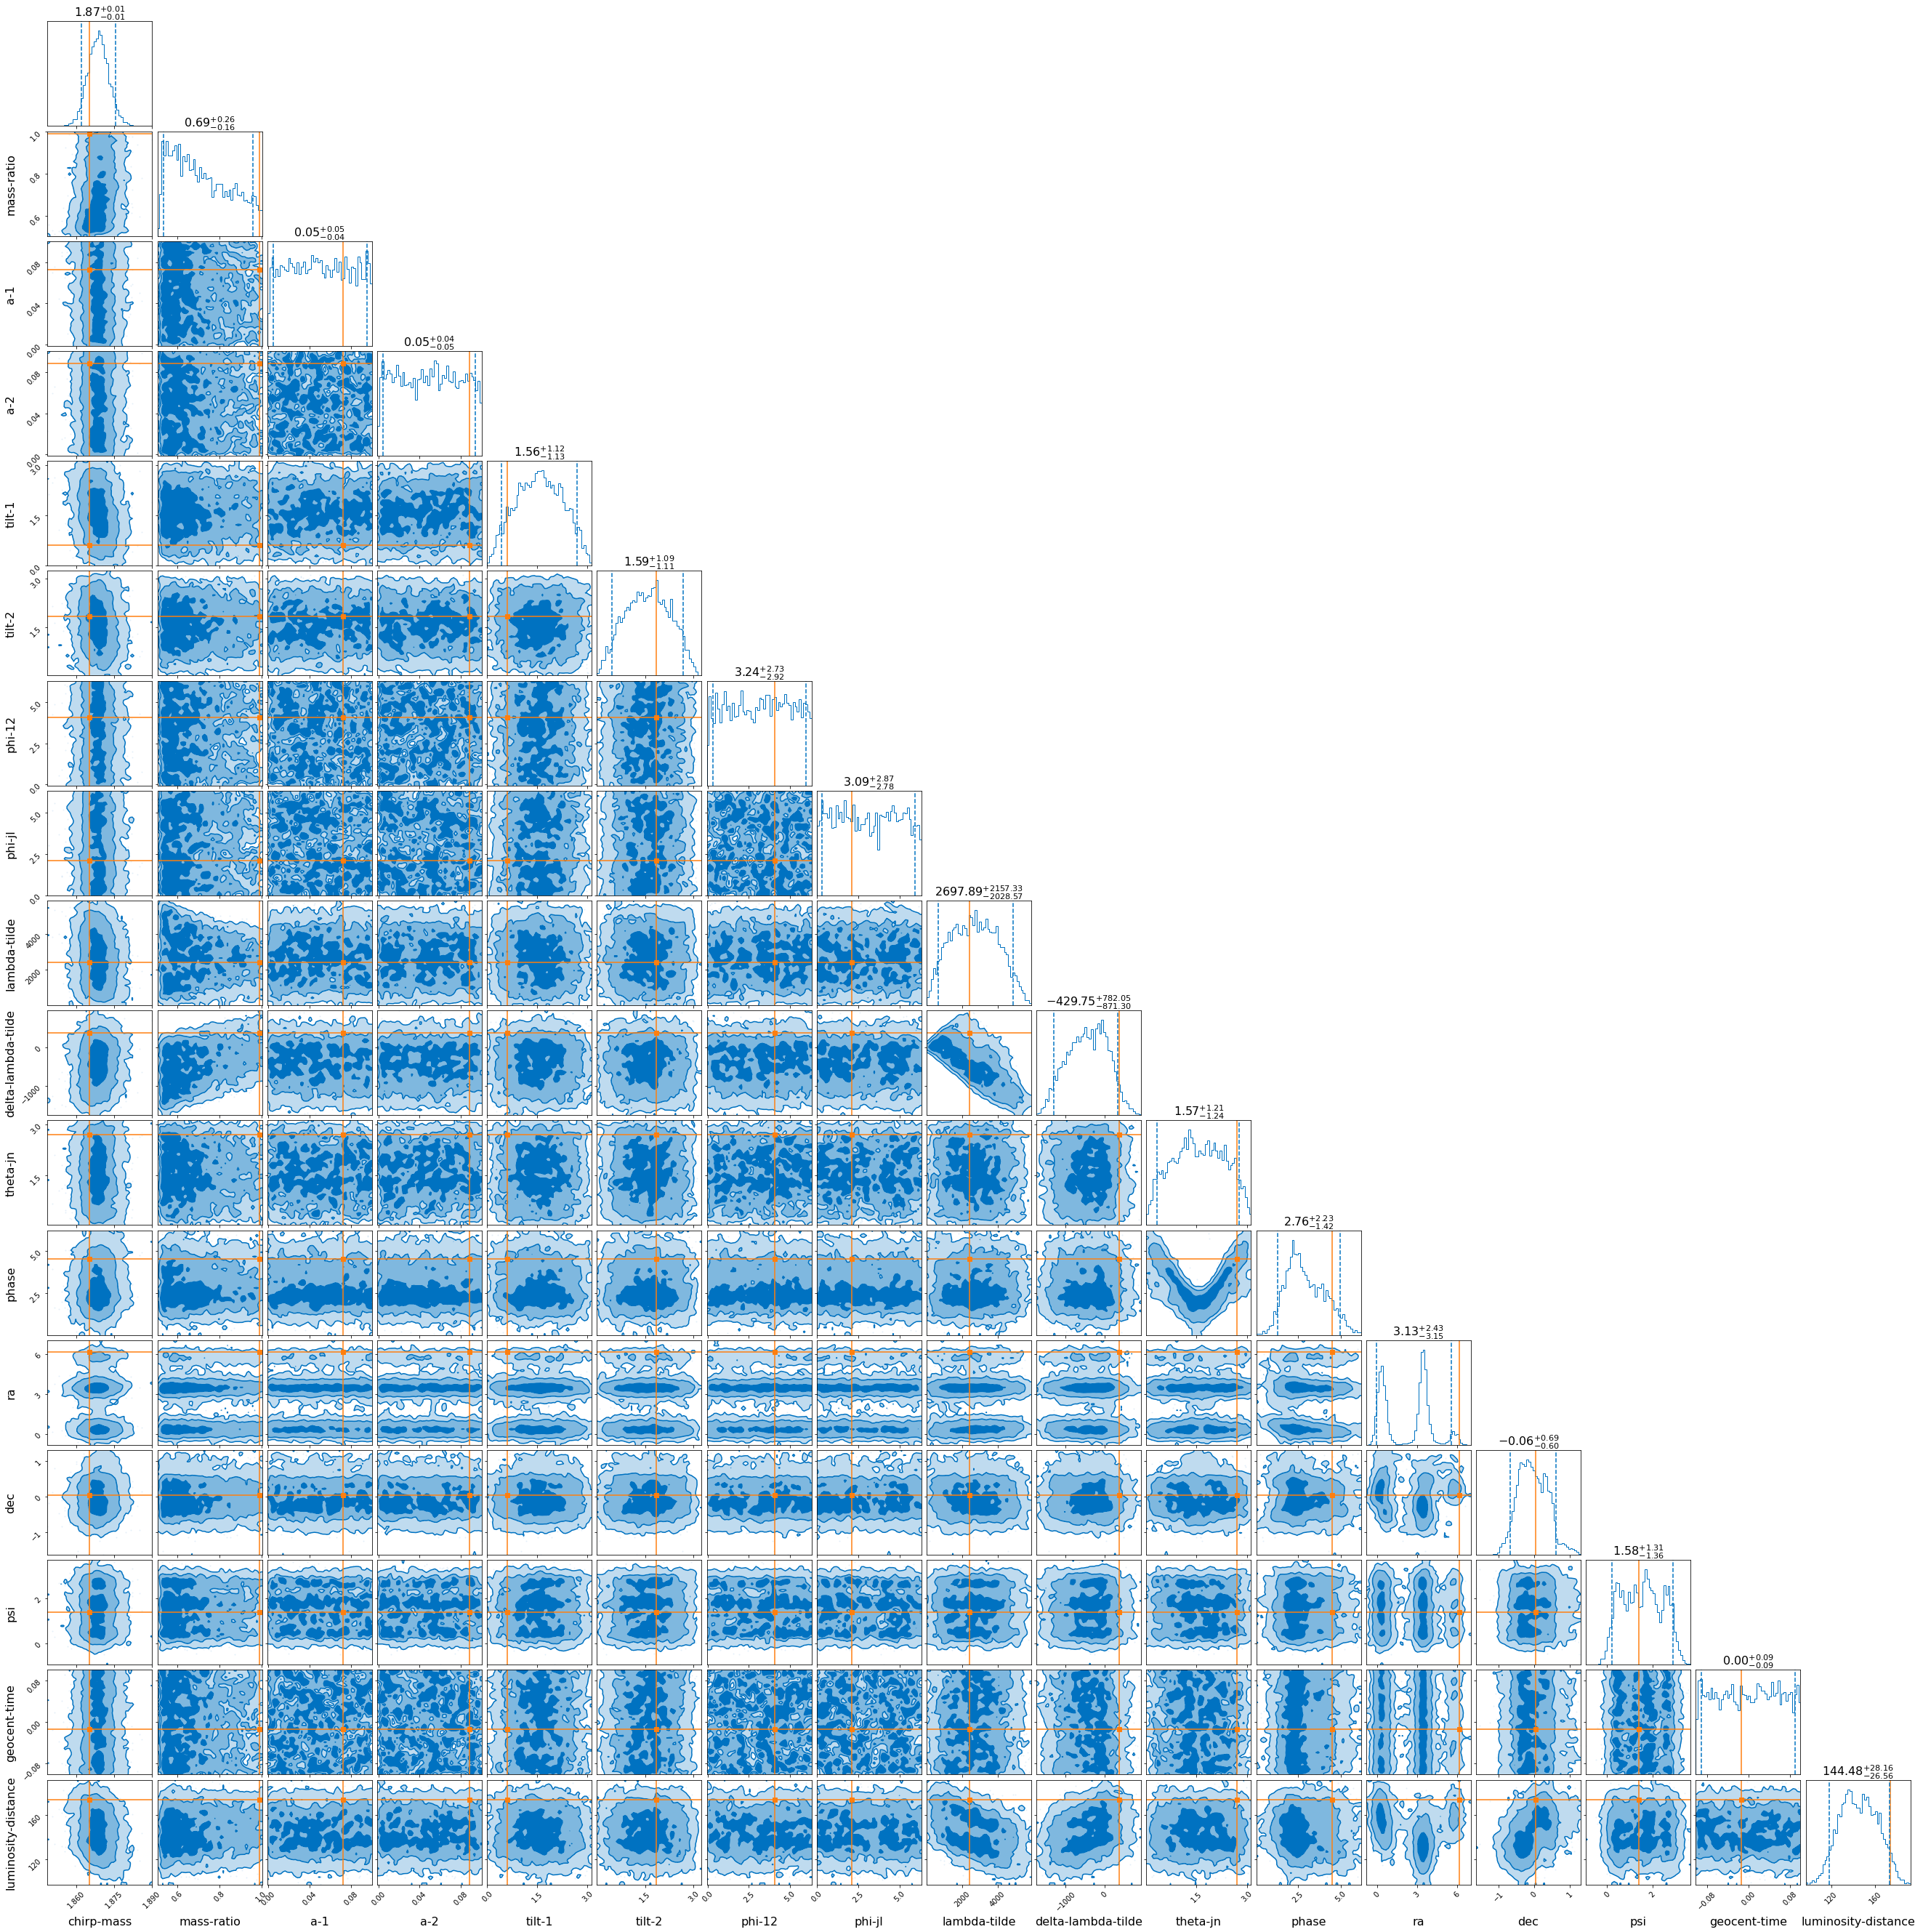

In [41]:
injdict = {}
#for i,paraname in enumerate(config_dict['data_generator_parameters']['context_parameter_names']):
for i,paraname in enumerate(parameter_names):
    injdict[paraname] = dataset_valid[0][0][i].cpu()

#result.injection_parameters = injdict
filename =  f"{config_path}/corner{look_index}.png"

plot_params = result.injection_parameters
fig = result.plot_corner(parameters=plot_params, save=False, filename = filename, quantiles=[0.05,0.95])





In [36]:
result_prior = bilby.core.result.read_in_result('/home/qian.hu/mlpe/river/scripts/outputs/prior_samples.pkl')
results = [result, result_prior]


/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)
/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)


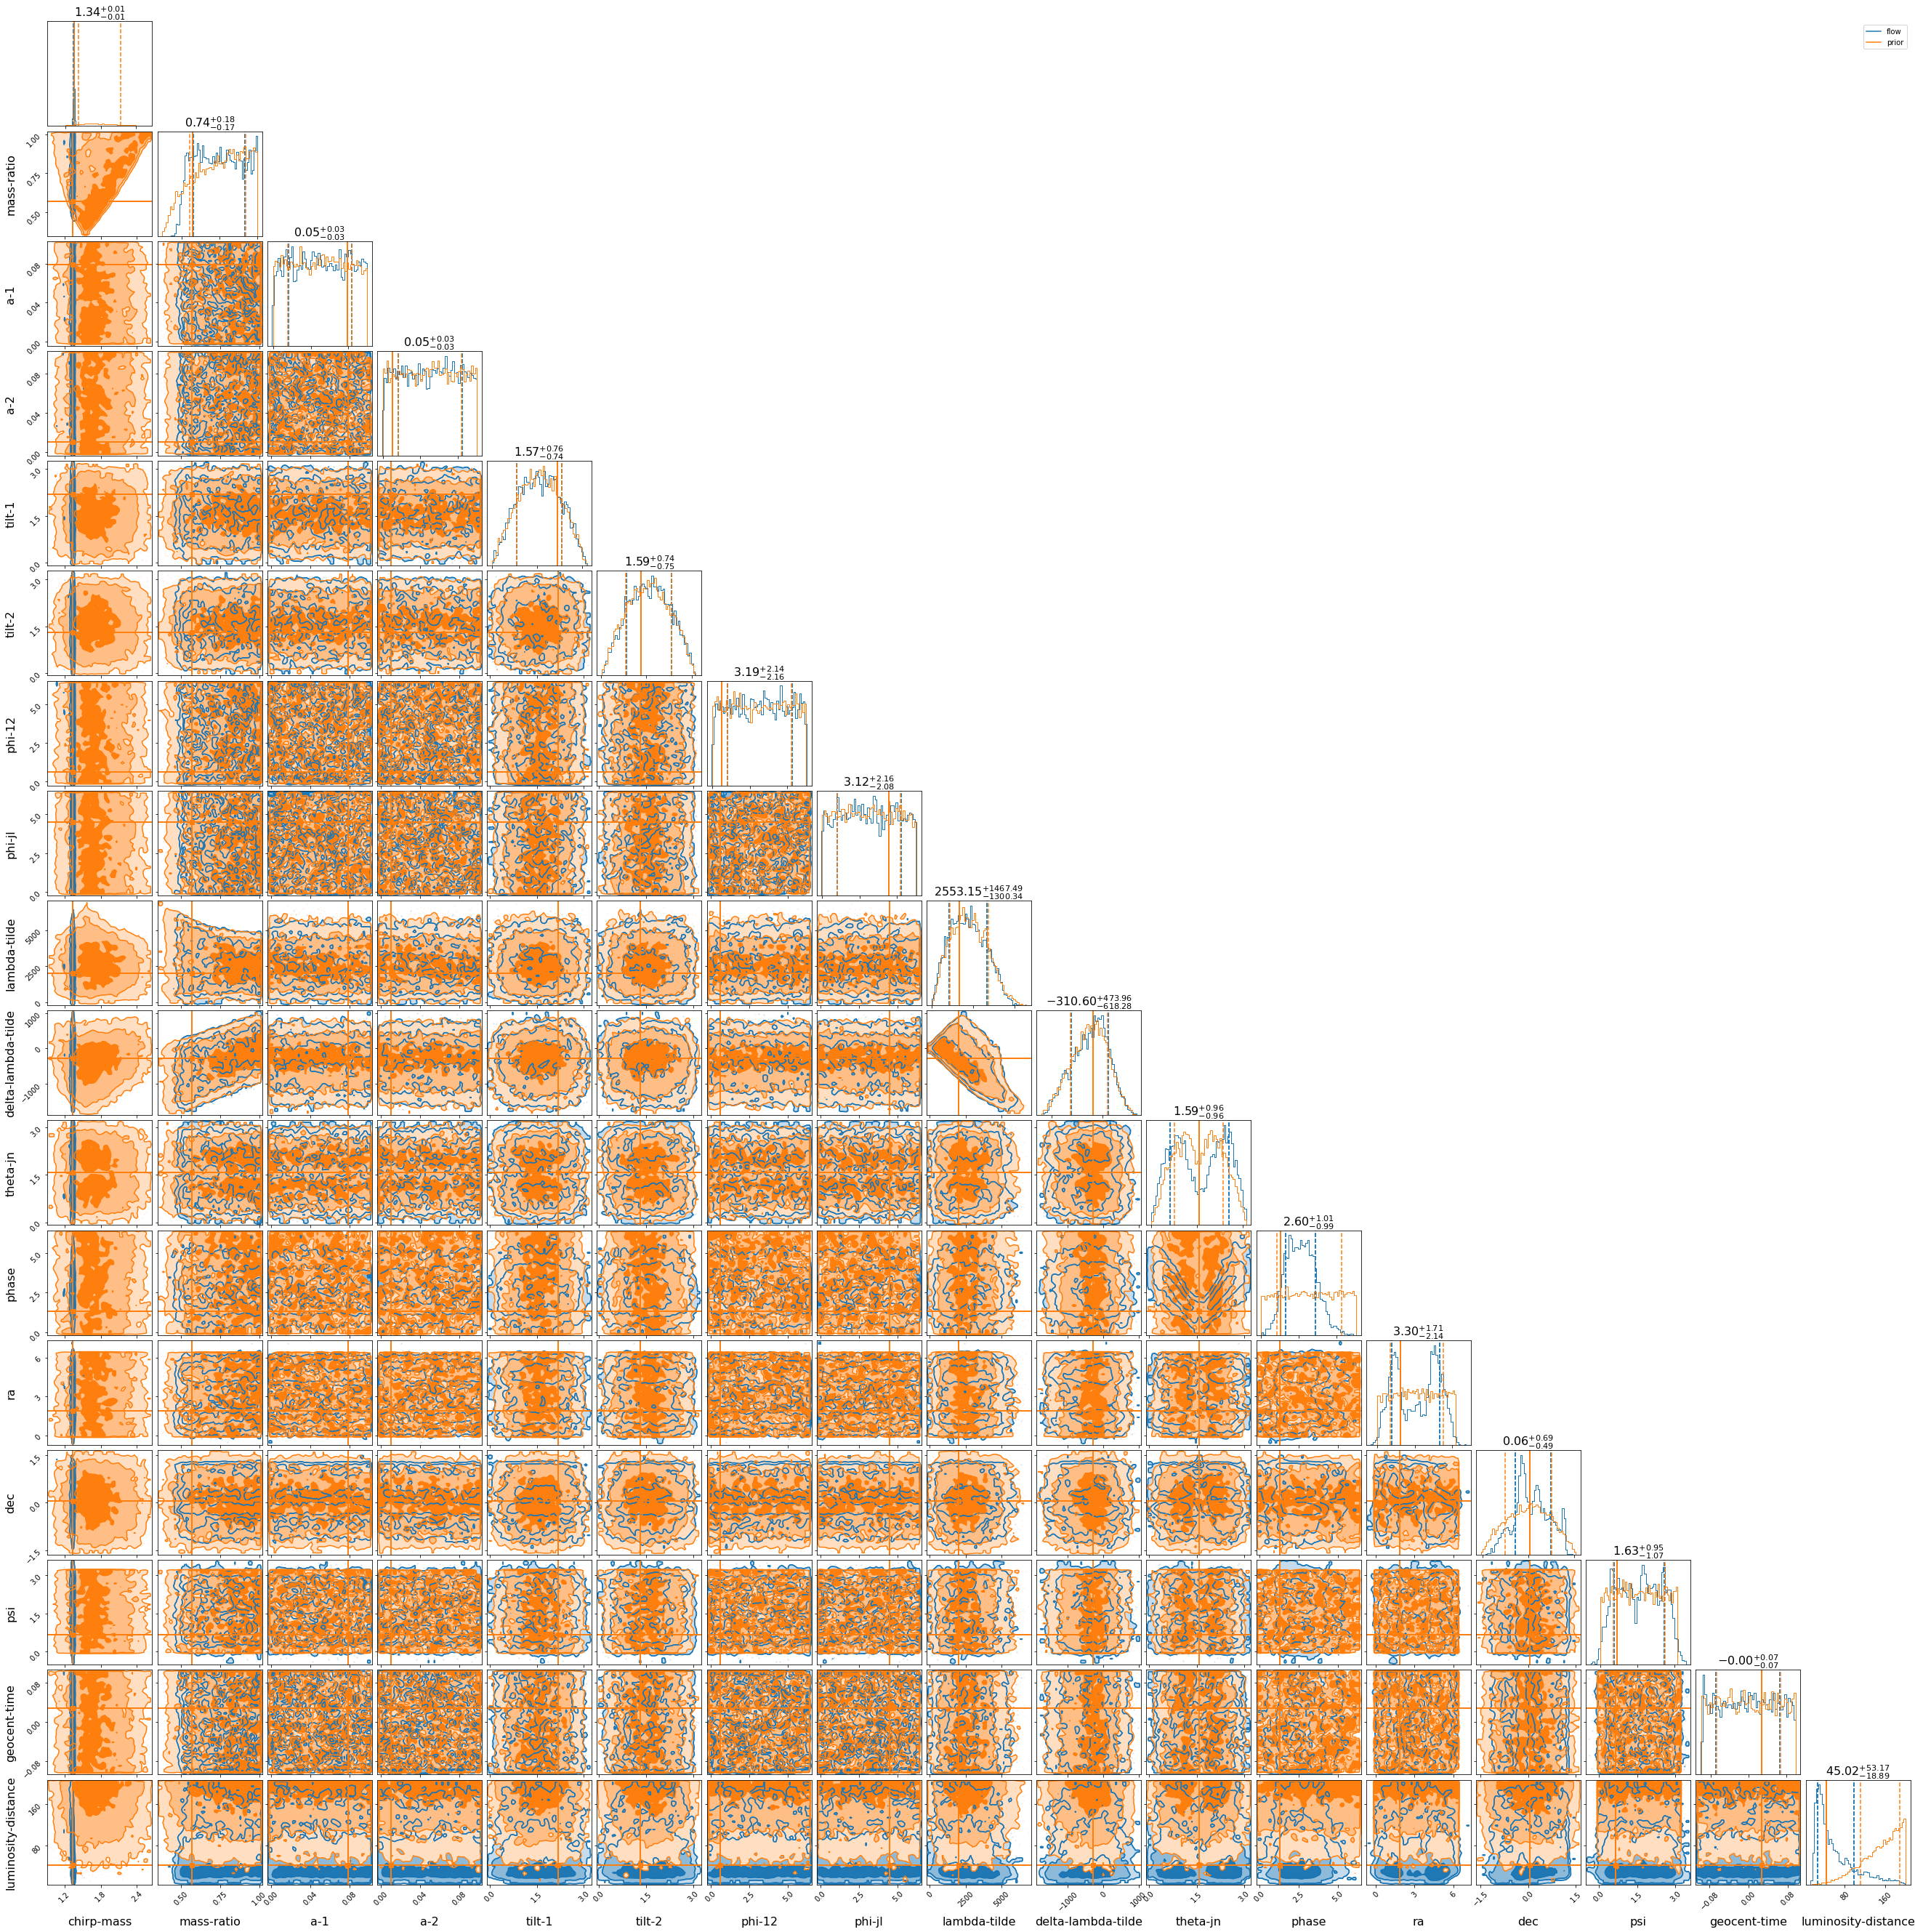

In [37]:
fig = bilby.core.result.plot_multiple(results, parameters=plot_params, filename=None, labels=['flow', 'prior'], colours=None, save=False, evidences=False, corner_labels=None, linestyles=None)

